In [19]:
import torch

from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import datasets,transforms,utils
import matplotlib.pyplot as plt

#train_data=datasets.MNIST(root='./MNIST',train=True,download=True,transform=transforms.ToTensor())
batch_size=256
# convert the image to tensor,rotate image,resize image and normalize it
transform = transforms.Compose([ transforms.ToTensor(),
                                 transforms.Normalize((0.1307,), (0.3081,))])
# Create a random 1/10th size subset of the data
# one_tenth = len(train_data) // 10
# train_data, _ = torch.utils.data.random_split(train_data, [one_tenth, len(train_data) - one_tenth])


# download dataset
train_set = datasets.MNIST(root='./MNIST', train=True, download=True, transform=transform)
test_set = datasets.MNIST(root='./MNIST', train=False, download=True, transform=transform)

# load dataset
train_loader=DataLoader(train_set,batch_size=batch_size,shuffle=True)
test_loader=DataLoader(test_set,batch_size=batch_size,shuffle=False)

for X, y in test_loader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([256, 1, 28, 28])
Shape of y: torch.Size([256]) torch.int64


/var/folders/9r/lj24dmsx0cz5p5mb2697_kfr0000gn/T/ipykernel_71475/2565360394.py:4: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


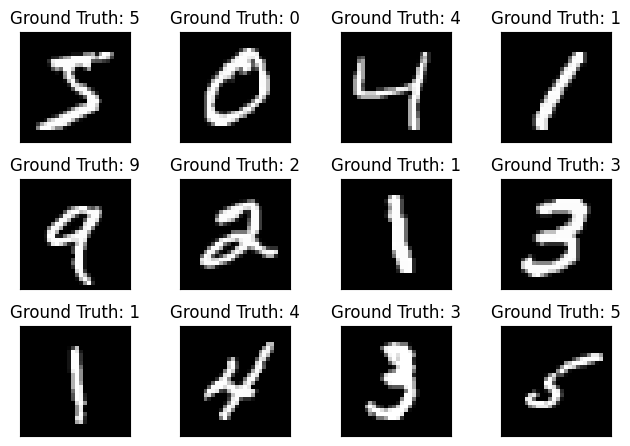

In [2]:
fig=plt.figure()
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.tight_layout()
    plt.imshow(train_set.data[i],cmap='gray',interpolation='none')
    plt.title("Ground Truth: {}".format(train_set.targets[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()

In [13]:
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 5), # in_channels, out_channels, kernel_size
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # kernel_size, stride
            nn.Conv2d(32, 64, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.fc = nn.Sequential(
            nn.Linear(64*4*4, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 10)
        )
    def forward(self, img):
        feature = self.conv(img)
        output = self.fc(feature.view(img.shape[0], -1))
        return output
model = MyNet()
print(model)



loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

MyNet(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=1024, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [4]:
# # Load the pre-trained weights
# model.load_state_dict(torch.load('/MNIST/best_letnet.pth'))
# model.eval()  # Set the model in evaluation mode

In [17]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)



In [18]:

# Training CNN
def train(dataloader, model, loss_fn, optimizer):
    model.train()
    total = 0
    correct = 0.0
    epoch_loss = 0.0

    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        epoch_loss += loss.item()
        predicted=pred.argmax(dim=1)
        total += y.size(0)
        correct += (predicted==y).sum().item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        L = len(dataloader)
        K = L // 10
        if batch % K == 0:
            accuracy = 100 * correct / total
            print(f"train loss:{loss.item():.3f}", end=" ")
            print(f"train accuracy:{accuracy:.2f}%")
    epoch_loss /= len(dataloader)
    return epoch_loss, accuracy


def test(testloader,model,loss_fn):
    model.eval()
    test_loss=0
    correct=0
    total=0
    with torch.no_grad():
        for X,y in testloader:
            pred=model(X)
            test_loss+=loss_fn(pred,y).item()
            predicted=pred.argmax(dim=1)
            total+=y.size(0)
            correct+=(predicted==y).sum().item()
        print("test loss:{:.3f},test accuracy:{:.2f}%".format(test_loss/total,100*correct/total))

    test_loss /= len(testloader)
    accuracy = 100 * correct / total
    return test_loss, accuracy



epochs = 10
max_accuracy = 0.0
# min_loss = float('inf')
lines = {
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": []
}
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss, train_acc = train(train_loader, model, loss_fn, optimizer)
    test_loss, test_acc = test(test_loader, model, loss_fn)

    if test_acc > max_accuracy:
        print("best model accuracy: ", test_acc, "previous best accuracy: ", max_accuracy)
        print("Save best model")
        max_accuracy = test_acc

        torch.save(model.state_dict(), 'best_lenet.pth')
        lines["train_loss"].append(train_loss)
        lines["train_acc"].append(train_acc)
        lines["test_loss"].append(test_loss)
        lines["test_acc"].append(test_acc)

print("Done!")


Epoch 1
-------------------------------
train loss:0.023 train accuracy:98.83%
train loss:0.092 train accuracy:98.68%
train loss:0.023 train accuracy:98.90%
train loss:0.015 train accuracy:98.88%
train loss:0.046 train accuracy:98.91%
train loss:0.009 train accuracy:98.94%
train loss:0.017 train accuracy:98.92%
train loss:0.034 train accuracy:98.91%
train loss:0.038 train accuracy:98.91%
train loss:0.029 train accuracy:98.93%
train loss:0.037 train accuracy:98.92%
test loss:0.000,test accuracy:99.20%
best model accuracy:  99.2 previous best accuracy:  0.0
Save best model
Epoch 2
-------------------------------
train loss:0.030 train accuracy:98.83%
train loss:0.027 train accuracy:99.14%
train loss:0.044 train accuracy:98.96%
train loss:0.023 train accuracy:98.91%
train loss:0.061 train accuracy:98.89%
train loss:0.016 train accuracy:98.94%
train loss:0.122 train accuracy:98.94%
train loss:0.084 train accuracy:98.93%
train loss:0.054 train accuracy:98.96%
train loss:0.012 train accuracy

In [ ]:
# check classification
example = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(example)
with torch.no_grad():
    output = model(example_data)
fig1=plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0],cmap='gray',interpolation='none')
    plt.title("Prediction: {}".format(
        output.data.max(1, keepdim=True)[1][i].item()))
    plt.xticks([])
    plt.yticks([])
plt.show()

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels)
#         print(predicted == labels)
        for i in range(10):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of number %d : %2d %%' % (
        i, 100 * class_correct[i] / class_total[i]))

In [23]:
# confusion matrix use sklearn and matplotlib
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import torch

y_true = []
y_pred = []
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true += labels.tolist()
        y_pred += predicted.tolist()

confusion_mat = confusion_matrix(y_true, y_pred)
print(confusion_mat)

[[ 978    0    0    0    0    0    0    0    1    1]
 [   0 1132    0    2    0    1    0    0    0    0]
 [   0    1 1030    0    0    0    0    1    0    0]
 [   0    0    1 1009    0    0    0    0    0    0]
 [   0    0    0    0  974    0    2    1    0    5]
 [   0    0    0    6    0  884    1    0    0    1]
 [   3    2    0    0    1    0  951    0    1    0]
 [   0    2    3    1    0    0    0 1020    0    2]
 [   1    0    2    1    1    0    0    1  965    3]
 [   0    0    0    0    3    2    0    2    1 1001]]


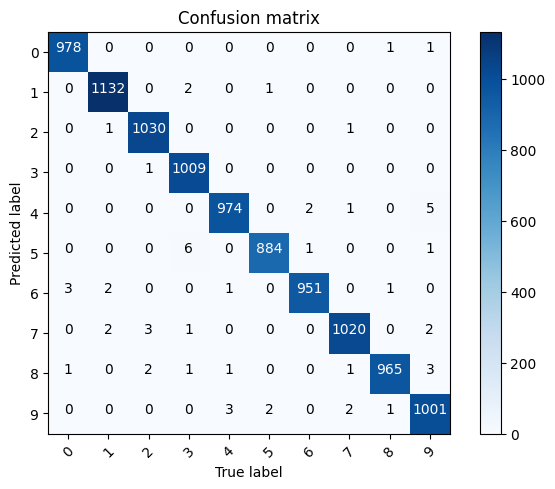

In [22]:
import itertools

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(10)
    plt.xticks(tick_marks, rotation=45)
    ax = plt.gca()
    ax.set_xticklabels((ax.get_xticks()).astype(str))
    plt.yticks(tick_marks)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Predicted label')
    plt.xlabel('True label')

plot_confusion_matrix(confusion_mat)

In [ ]:
# row is true label, column is predicted label
# e.g. 0 is classified as 0 977 times out of 980
# diagonal shows that most digits are classified correctly
# off diagonal numbers show misclassified digits
# e.g. 4 and 9 are often misclassified as each other